## Clasificador de Noticias Argentinas 

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [2]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [3]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [4]:
len(df)

26961

In [5]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Entretenimiento         3850
Internacional           3850
Economia                3850
Salud                   3840
Name: categoria, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
25025,"Las ventas minoristas cayeron 15,6% en noviemb...",Economia
13936,"Cómo la fiscal que habló de ""empalamiento"" en ...",Nacional
5850,El Reino Unido y la UE acuerdan un proyecto so...,Internacional
22379,La reacción del Polaco al enterarse de que Cal...,Entretenimiento
13075,"Tristeza, lamento y vergÃ¼enza ajena: qué opin...",Deportes


In [7]:
textos = list(df['titular'])

In [8]:
# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { i : {} for i in categories }

In [9]:
print(categories_word_appearances)

{'Nacional': {}, 'Deportes': {}, 'Salud': {}, 'Ciencia y Tecnologia': {}, 'Entretenimiento': {}, 'Economia': {}, 'Internacional': {}}


In [10]:
import re

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x), words))  # reemplazo de símbolos por ningún caracter
    return words

for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)
    
    for word in words:
            if word in categories_word_appearances[category]:
                categories_word_appearances[category][word] += 1
            else:
                categories_word_appearances[category][word] = 1
                
    
    
    

In [11]:
print(categories_word_appearances['Entretenimiento']['Pampita'])

65


In [12]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { i : {} for i in categories }
zero_probabilities = { i : 0 for i in categories } # Laplace correction in case a word does not appear in a category
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))
    zero_probabilities[category] = 1 / laplace_denominator
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator

print(word_relative_frequencies['Entretenimiento']['Pampita'])
# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Economia                0.144659
Nacional                0.144010
Entretenimiento         0.143082
Salud                   0.142572
Deportes                0.142526
Ciencia y Tecnologia    0.142526
Internacional           0.140625
Name: categoria, dtype: float64
0.0014044346086734478


In [13]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
        vs[category] = v
    mx = (None, 0)
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
La noticia 'Messi metió un gol' pertenece a Deportes
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


{'Nacional': {'Nacional': 689, 'Deportes': 13, 'Salud': 11, 'Ciencia y Tecnologia': 2, 'Entretenimiento': 6, 'Economia': 15, 'Internacional': 18}, 'Deportes': {'Nacional': 3, 'Deportes': 754, 'Salud': 7, 'Ciencia y Tecnologia': 1, 'Entretenimiento': 8, 'Economia': 3, 'Internacional': 5}, 'Salud': {'Nacional': 1, 'Deportes': 0, 'Salud': 753, 'Ciencia y Tecnologia': 2, 'Entretenimiento': 0, 'Economia': 2, 'Internacional': 7}, 'Ciencia y Tecnologia': {'Nacional': 0, 'Deportes': 1, 'Salud': 8, 'Ciencia y Tecnologia': 770, 'Entretenimiento': 0, 'Economia': 3, 'Internacional': 0}, 'Entretenimiento': {'Nacional': 5, 'Deportes': 8, 'Salud': 6, 'Ciencia y Tecnologia': 5, 'Entretenimiento': 728, 'Economia': 5, 'Internacional': 7}, 'Economia': {'Nacional': 4, 'Deportes': 2, 'Salud': 4, 'Ciencia y Tecnologia': 15, 'Entretenimiento': 1, 'Economia': 701, 'Internacional': 3}, 'Internacional': {'Nacional': 27, 'Deportes': 3, 'Salud': 22, 'Ciencia y Tecnologia': 12, 'Entretenimiento': 10, 'Economia': 1

<AxesSubplot:>

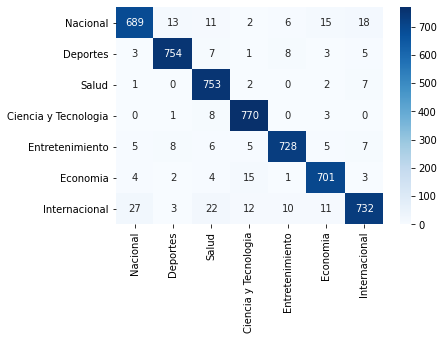

In [14]:
confusion_matrix = { i : {} for i in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { i : 0 for i in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

print(confusion_matrix)
confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
print('')
print(confusion_df)
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)
print('')
print(confusion_df)

import seaborn as sns
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [15]:
import numpy as np

true = []
predicted = []

for i in range(len(test)):
    row = test.iloc[i]
    true.append(row['categoria'])
    title = row['titular']
    predicted.append(classify(title))

    
# Calculamos las metricas para cada categoria    
    
category_metrics = { i : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0,  'f1': 0} for i in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)
metrics_df.head()

# Calculamos las metricas para el classifier en general (checkear cual es la forma correcta)
    
tp, fp, fn = 0, 0, 0


for i, category in enumerate(categories):
    tp += confusion_df.iloc[i, i]
    fp += sum(confusion_df.iloc[i, :i])
    fn += sum(confusion_df.iloc[i, i+1:])
    
tn = confusion_df.to_numpy().sum() - (fp + fn + tp)

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

metrics_df.head()

    



,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,689,4438,40,65,0.979931,0.945130,0.913793,0.929198
Deportes,754,4373,27,27,0.989577,0.965429,0.965429,0.965429
Salud,753,4374,58,12,0.986531,0.928483,0.984314,0.955584
Ciencia y Tecnologia,770,4357,37,12,0.990533,0.954151,0.984655,0.969163
Entretenimiento,728,4399,25,36,0.988242,0.966799,0.952880,0.959789


In [16]:
# Calcular curva ROC
u = [0.1 * x for x in range(1, 10)]

def calc_word_prob(word):
    totalCount, wordCount = 0, 0
    for category in categories:
        
        for key in categories_word_appearances[category].keys():
            totalCount += categories_word_appearances[category][key]
        
        if word in categories_word_appearances[category]:
            wordCount += categories_word_appearances[category][word]
    # print(f"wordCount / float(totalCount): {wordCount / float(totalCount)}")  
    return (wordCount + 1) / float(totalCount)
    
    
    

def classify_with_prob(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            # word count / total de apariciones de todas las palabras
            word_prob = calc_word_prob(word)
            
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word] / word_prob
            else:
                v *= zero_probabilities[category]
        vs[category] = v 
    
    return vs

classification_probs = []

for j in u:
    for i in range(10):#len(test)):
        row = test.iloc[0]
        category = row['categoria']
        title = row['titular']
        classification_probs.append(classify_with_prob(title))

print(classification_probs)

        
    
    
    



[{'Nacional': 1.1711616387089635e-18, 'Deportes': 1.6683970711347884e-22, 'Salud': 3.5213588788031577e-26, 'Ciencia y Tecnologia': 9.640219513821542e-23, 'Entretenimiento': 9.247575539311461e-32, 'Economia': 774036.5371540333, 'Internacional': 6.317695568383113e-22}, {'Nacional': 1.1711616387089635e-18, 'Deportes': 1.6683970711347884e-22, 'Salud': 3.5213588788031577e-26, 'Ciencia y Tecnologia': 9.640219513821542e-23, 'Entretenimiento': 9.247575539311461e-32, 'Economia': 774036.5371540333, 'Internacional': 6.317695568383113e-22}, {'Nacional': 1.1711616387089635e-18, 'Deportes': 1.6683970711347884e-22, 'Salud': 3.5213588788031577e-26, 'Ciencia y Tecnologia': 9.640219513821542e-23, 'Entretenimiento': 9.247575539311461e-32, 'Economia': 774036.5371540333, 'Internacional': 6.317695568383113e-22}, {'Nacional': 1.1711616387089635e-18, 'Deportes': 1.6683970711347884e-22, 'Salud': 3.5213588788031577e-26, 'Ciencia y Tecnologia': 9.640219513821542e-23, 'Entretenimiento': 9.247575539311461e-32, 'Ec